# main

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

mpl.rc("figure", dpi=150)
mpl.rc("figure", figsize=(4,4))

plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'xtick.labelsize':15,
    'ytick.labelsize':15,
    'axes.labelsize':20,
})

import os
import re

In [2]:
# extra stuff
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter
import math
from scipy.spatial import cKDTree  # For finding nearest neighbors

# formatting
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2, 2))  # Sets limits for when to use scientific notation

In [3]:
# output directory
dir = '../data.lbm/'
# dir = '../src/2/output.lbm/'

# all ticks are found using regular expressions
files = os.listdir(dir)
ticks = []

pattern = r'fluidTrj_(\d+)\.csv'

for file in files:
    match = re.search(pattern, file)
    if match:
        ticks.append(int(match.group(1)))
        
ticks.sort()

len(ticks)

101

# Fluido

In [6]:
fluidDf = pd.read_csv(dir + f"fluidTrj_{ticks[-1]}.csv").set_index(["id_x","id_y"]).sort_index()

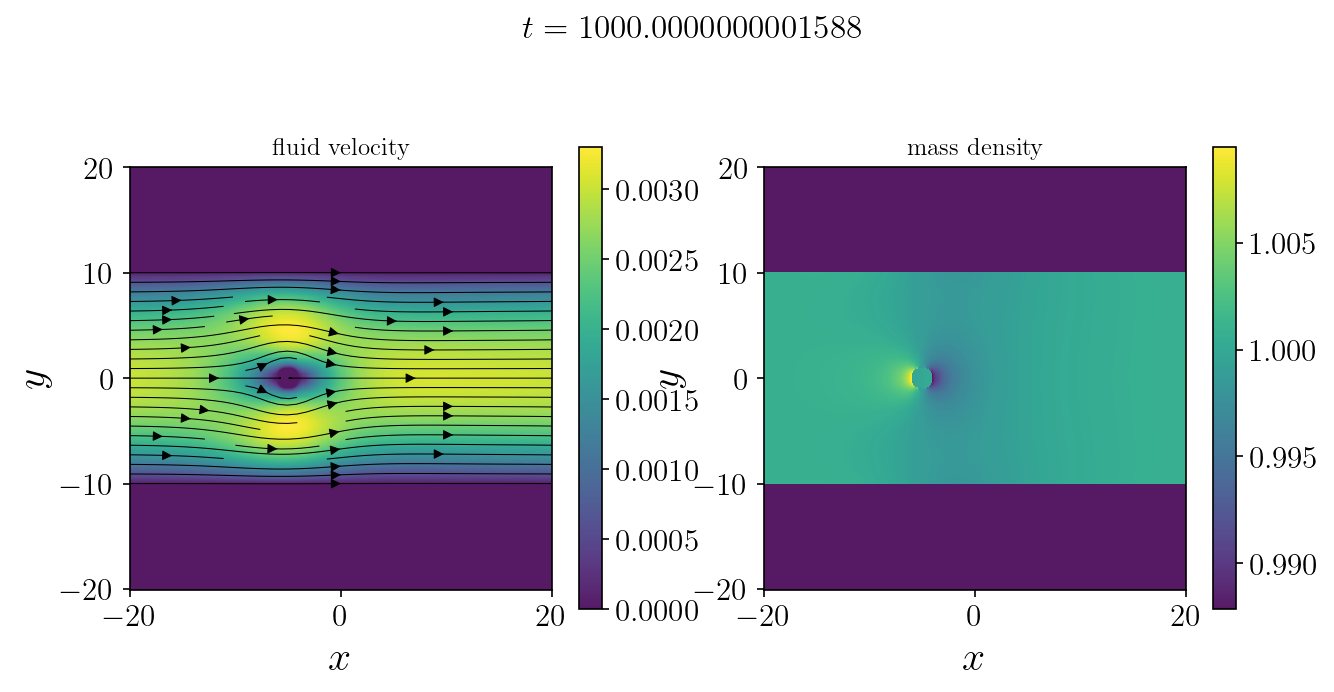

In [9]:
fig, axes = plt.subplots(1, 2, figsize = (10,5))

# Add a title for the whole figure
fig.suptitle(f"$t = {fluidDf.time.values[0]}$", fontsize=16)

# Create a meshgrid for plotting
x_unique = fluidDf['coordinate_x'].unique()
y_unique = fluidDf['coordinate_y'].unique()
X, Y = np.meshgrid(x_unique, y_unique)

cs = []

axes[0].streamplot(X, Y, 
    fluidDf.fluidVelocity_x.unstack().values.transpose(),
    fluidDf.fluidVelocity_y.unstack().values.transpose(),
    density=1.5, linewidth=0.5, color="black",
)

c = axes[0].pcolormesh(X, Y,
    np.sqrt(fluidDf.fluidVelocity_x**2 + fluidDf.fluidVelocity_y**2).unstack().values.transpose(),
    cmap = "viridis", alpha = 0.9
); cs.append(c);
axes[0].set_title('fluid velocity')

c = axes[1].pcolormesh(X,Y,
    fluidDf.massDensity.unstack().values.transpose(),
    vmin=min(fluidDf.query("massDensity > 0").massDensity.values),
    cmap = "viridis", alpha = 0.9
); cs.append(c);
axes[1].set_title('mass density')

for i in range(len(axes)):
    ax = axes.flatten()[i]
    c = cs[i]
    ax.set_aspect('equal')
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    cbar = fig.colorbar(c, ax=ax, shrink=.8)
    cbar.ax.yaxis.set_major_formatter(formatter)
    cbar.ax.yaxis.get_offset_text().set_fontsize(10)  # Adjust the font size if necessary

plt.show()

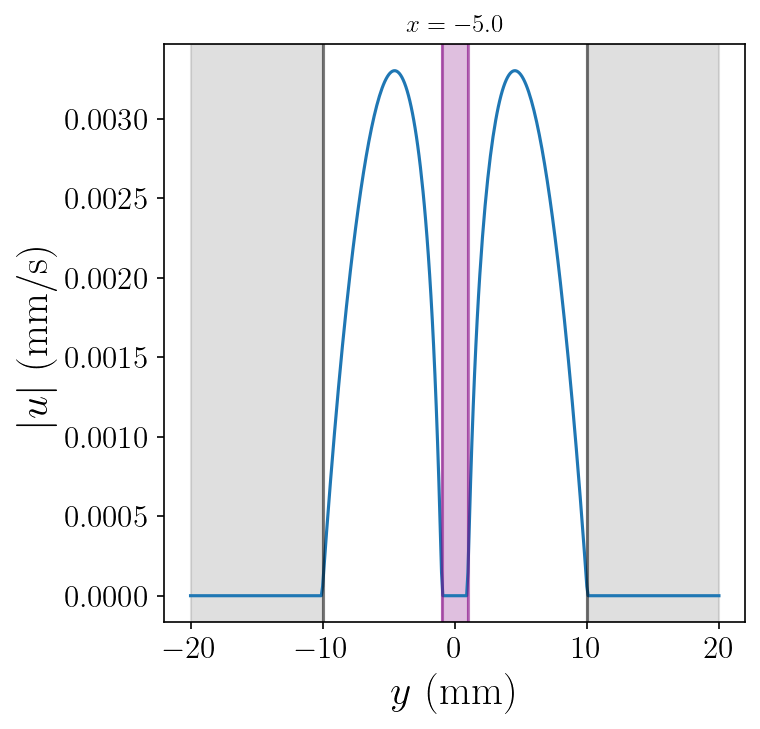

In [10]:
v_x = fluidDf.query("coordinate_x == -5").filter(["coordinate_x","coordinate_y","fluidVelocity_x","fluidVelocity_y"])

fig, ax = plt.subplots(figsize = (5,5))

ax.plot(v_x.coordinate_y, np.sqrt(v_x.fluidVelocity_x**2 + v_x.fluidVelocity_y**2)) 
ax.set_xlabel("$y$ (mm)")
ax.set_ylabel("$|u|$ (mm/s)")
ax.set_title(f"$x = {v_x.coordinate_x.values[0]}$")
ax.axvline(-10, color = "k", alpha = 0.5)
ax.axvline(10, color = "k", alpha = 0.5)
ax.axvspan(-20, -10, color='gray', alpha=0.25)  # Shade the wall
ax.axvspan(20, 10, color='gray', alpha=0.25)  # Shade the wall
ax.axvline(-1, color = "purple", alpha = 0.5)
ax.axvline(1, color = "purple", alpha = 0.5)
ax.axvspan(-1, 1, color='purple', alpha=0.25)  # Shade the wall

plt.show()

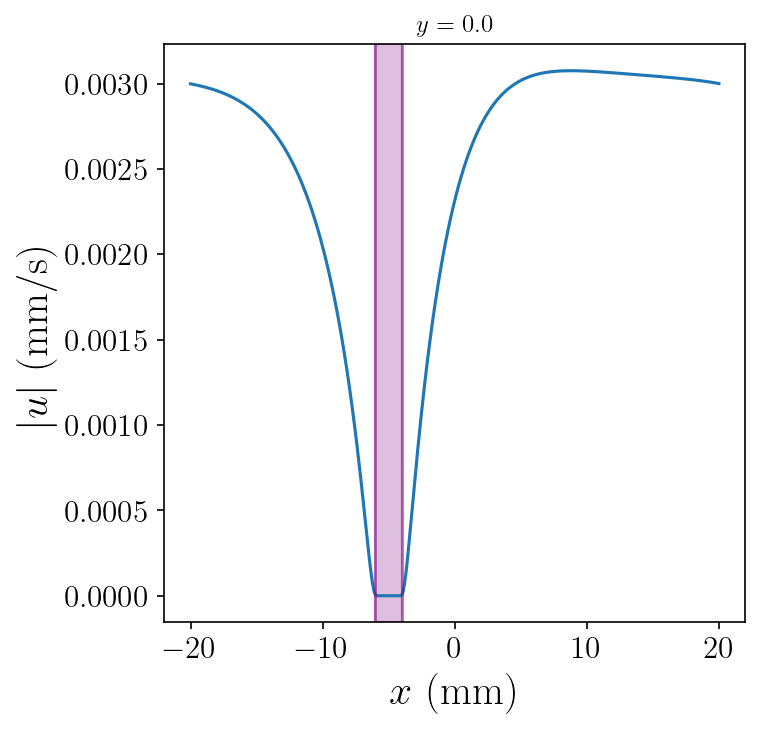

In [11]:
v_x = fluidDf.query("coordinate_y == 0").filter(["coordinate_x", "coordinate_y", "fluidVelocity_x", "fluidVelocity_y"])

fig, ax = plt.subplots(figsize = (5,5))

ax.plot(v_x.coordinate_x, np.sqrt(v_x.fluidVelocity_x**2 + v_x.fluidVelocity_y**2)) 
ax.set_xlabel("$x$ (mm)")
ax.set_ylabel("$|u|$ (mm/s)")
ax.set_title(f"$y = {v_x.coordinate_y.values[0]}$")
ax.axvline(-1-5, color = "purple", alpha = 0.5)
ax.axvline(1-5, color = "purple", alpha = 0.5)
ax.axvspan(-1-5, 1-5, color='purple', alpha=0.25)  # Shade the wall
# ax.legend(loc='upper right')

plt.show()

In [12]:
def maxSpeed(df):
    return np.sqrt(df.fluidVelocity_x**2 + df.fluidVelocity_y**2).max()

maximumFluidSpeed = [
    maxSpeed(pd.read_csv(dir + f"fluidTrj_{tick}.csv"))
for tick in ticks]
time = [pd.read_csv(dir + f"fluidTrj_{tick}.csv").time.values[0] for tick in ticks]

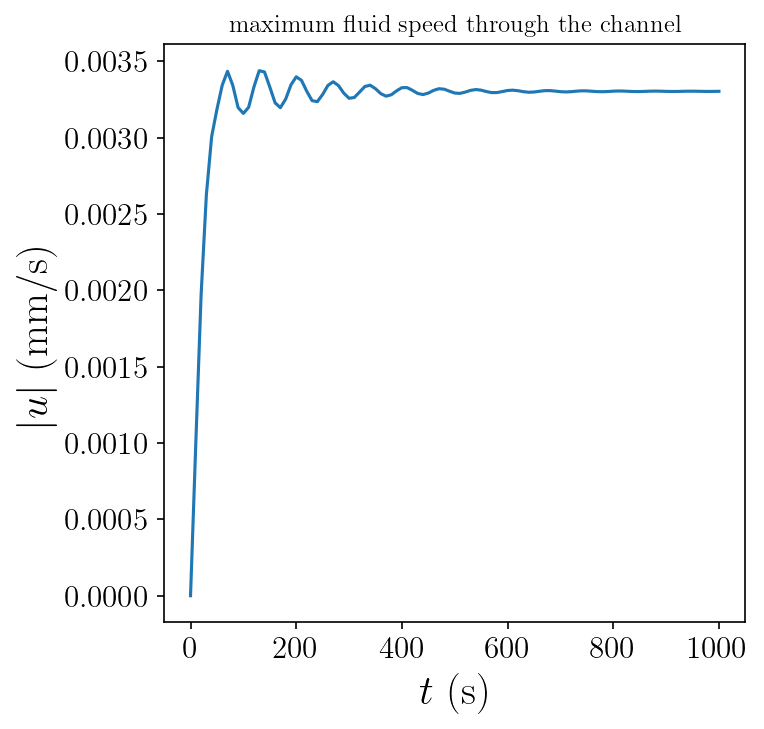

In [13]:
fig, ax = plt.subplots(figsize = (5,5))

ax.plot(time, maximumFluidSpeed)
ax.set_title("maximum fluid speed through the channel")
ax.set_xlabel("$t$ (s)")
ax.set_ylabel("$|u|$ (mm/s)")

plt.show()

# Tensor de estrés

In [14]:
stressDf = pd.read_csv(dir + "stressTensor.csv").set_index(["id_x","id_y"]).sort_index()

stressDf

tick    time  coordinate_x  coordinate_y  component_xx  \
id_x id_y                                                            
1    1     10000  1000.0         -20.0         -20.0          -0.0   
     2     10000  1000.0         -20.0         -19.9          -0.0   
     3     10000  1000.0         -20.0         -19.8          -0.0   
     4     10000  1000.0         -20.0         -19.7          -0.0   
     5     10000  1000.0         -20.0         -19.6          -0.0   
...          ...     ...           ...           ...           ...   
401  397   10000  1000.0          20.0          19.6          -0.0   
     398   10000  1000.0          20.0          19.7          -0.0   
     399   10000  1000.0          20.0          19.8          -0.0   
     400   10000  1000.0          20.0          19.9          -0.0   
     401   10000  1000.0          20.0          20.0          -0.0   

           component_yx  component_xy  component_yy  
id_x id_y                                            
1    1             -0.0          -0.0          -0.0  
     2             -0.0          -0.0          -0.0  
     3             -0.0          -0.0          -0.0  
     4             -0.0          -0.0          -0.0  
     5             -0.0          -0.0          -0.0  
...                 ...           ...           ...  
401  397           -0.0          -0.0          -0.0  
     398           -0.0          -0.0          -0.0  
     399           -0.0          -0.0          -0.0  
     400           -0.0          -0.0          -0.0  
     401           -0.0          -0.0          -0.0  

[160801 rows x 8 columns]

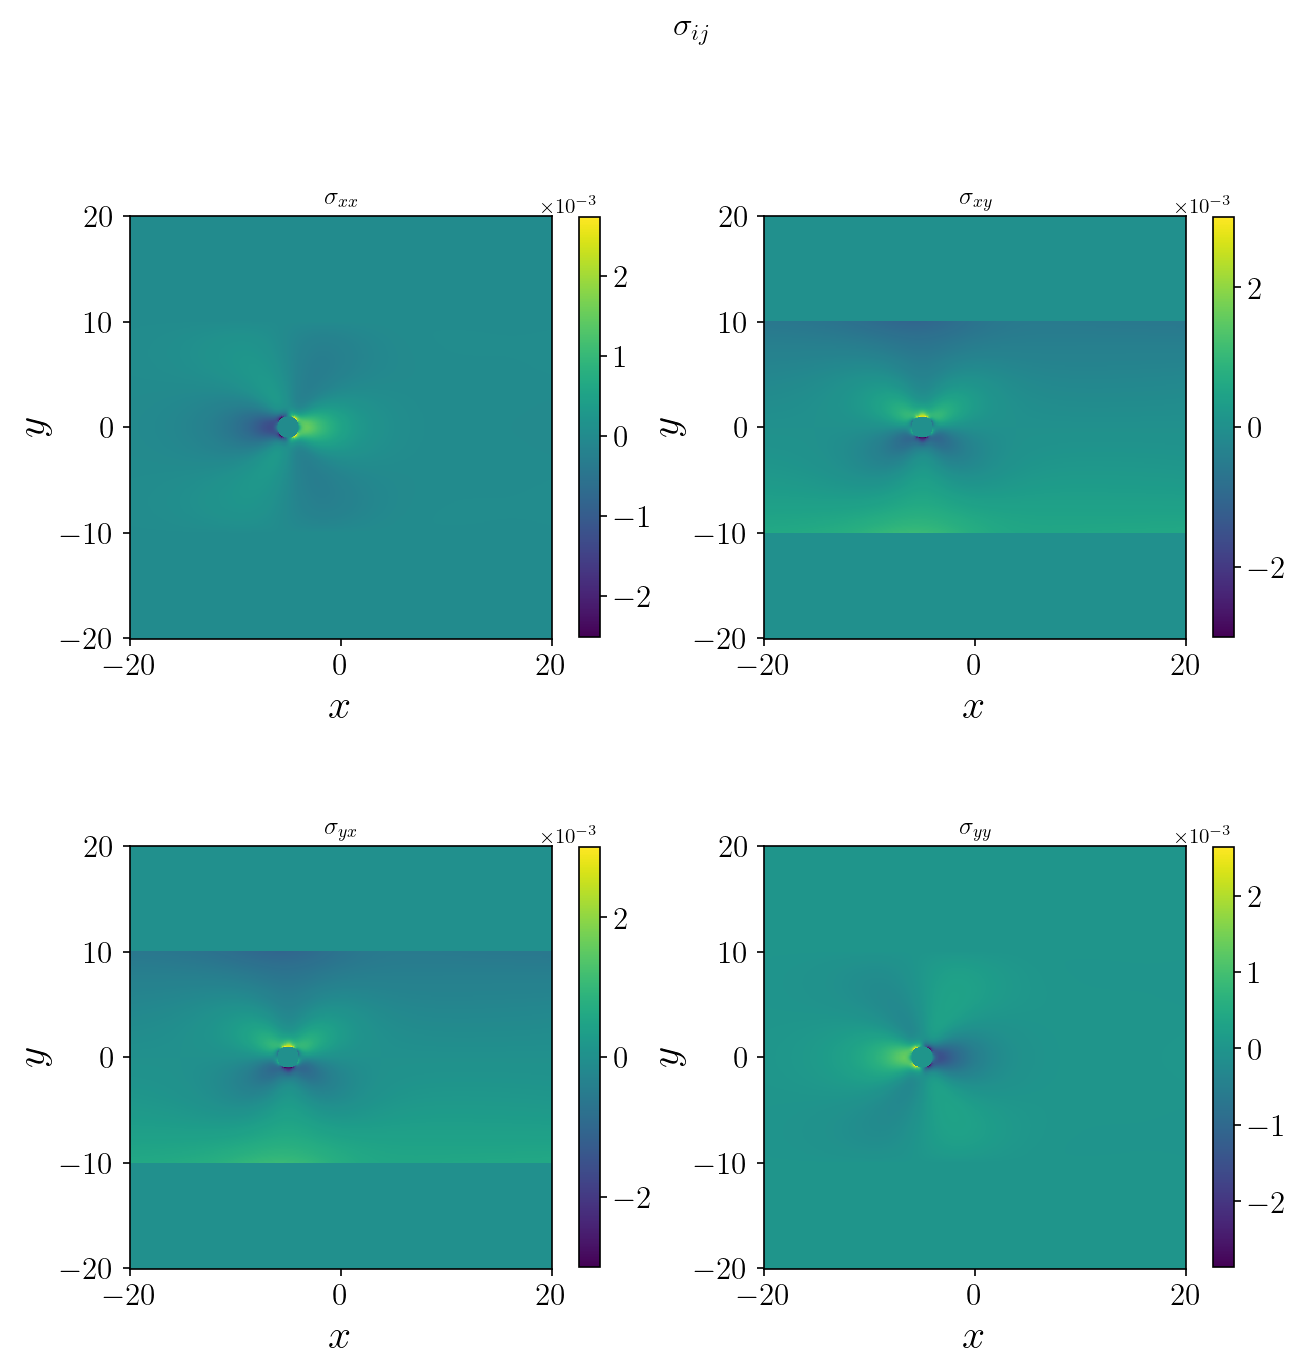

In [15]:
# setting up stuff
fig, axes = plt.subplots(2,2,figsize = (10,10))

# Add a title for the whole figure
fig.suptitle("$\\sigma_{ij}$", fontsize=16)

# Create a meshgrid for plotting
x_unique = stressDf['coordinate_x'].unique()
y_unique = stressDf['coordinate_y'].unique()
X, Y = np.meshgrid(x_unique, y_unique)

cs = []

# plotting
c = axes[0,0].pcolormesh(X,Y,stressDf["component_xx"].unstack().values.transpose()); cs.append(c);
axes[0,0].set_title("$\\sigma_{xx}$")

c = axes[0,1].pcolormesh(X,Y,stressDf["component_xy"].unstack().values.transpose()); cs.append(c);
axes[0,1].set_title("$\\sigma_{xy}$")

c = axes[1,0].pcolormesh(X,Y,stressDf["component_yx"].unstack().values.transpose()); cs.append(c);
axes[1,0].set_title("$\\sigma_{yx}$")

c = axes[1,1].pcolormesh(X,Y,stressDf["component_yy"].unstack().values.transpose()); cs.append(c);
axes[1,1].set_title("$\\sigma_{yy}$")


# for ax in axes.flat:
for i in range(4):
    ax = axes.flatten()[i]
    c = cs[i]
    ax.set_aspect('equal')
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")    
    cbar = fig.colorbar(c, ax=ax, shrink=.8)
    cbar.ax.yaxis.set_major_formatter(formatter)
    cbar.ax.yaxis.get_offset_text().set_fontsize(10)  # Adjust the font size if necessary
#     ax.axhline(wallPosition, color = "k", alpha = 0.1)
#     ax.axhspan(-2, wallPosition, color='gray', alpha=0.1)  # Shade the wall

plt.show()

# Winter meeting figures

In [4]:
fluidDf = pd.read_csv(dir + f"fluidTrj_{ticks[-1]}.csv").set_index(["id_x","id_y"]).sort_index()

In [55]:
def fluidOverview(df):
    df = df.query('coordinate_y <= 10 & coordinate_y >= -10')
    # figure preparation
#     fig, axes = plt.subplots(figsize = (5,2.5))
    fig, axes = plt.subplots(2, 1, figsize = (5,5))

#     fig.suptitle(f"$t = {fluidDf.time.values[0]:.0f}$", fontsize=16)
    fig.subplots_adjust(right=0.875)  # Adjust the right space to make room for the colorbar


    # Create a meshgrid for plotting
    x_unique = df['coordinate_x'].unique()
    y_unique = df['coordinate_y'].unique()
    X, Y = np.meshgrid(x_unique, y_unique)

    # first plot
    upperLim = 0.003
    lowerLim = 0.
    cmap = plt.get_cmap('cividis')
    norm = plt.Normalize(lowerLim, upperLim)

    axes[0].streamplot(X, Y, 
        df.fluidVelocity_x.unstack().values.transpose(),
        df.fluidVelocity_y.unstack().values.transpose(),
        density=0.85, linewidth=0.5, color="black",
    )
    
    
    axes[0].pcolormesh(X, Y,
        np.sqrt(df.fluidVelocity_x**2 + df.fluidVelocity_y**2).unstack().values.transpose(),
        vmin=lowerLim,
        vmax=upperLim,
        cmap=cmap, alpha = 0.85
    );
#     axes[0].tick_params(labelbottom=False)
    axes[0].set_xticks([-20, 0, 20])
    axes[0].set_xlabel("$x ~ (\\mathrm{mm})$")
    axes[0].set_yticks([-10, 0, 10])
    axes[0].set_ylabel("$y ~ (\\mathrm{mm})$")
    
#     maskStep = int(len(x_unique)/20)
#     # Create a mask for filtering
#     mask = (df['coordinate_x'].isin(x_unique[::maskStep])) & (df['coordinate_y'].isin(y_unique[::maskStep])) & (
#         (df.fluidVelocity_x**2 + df.fluidVelocity_y**2 > 1e-16)
#     )
#     # Filter the DataFrame
#     filtered_df = df[mask]
    
#     axes.quiver(
#         filtered_df['coordinate_x'], 
#         filtered_df['coordinate_y'], 
#         (filtered_df.fluidVelocity_x / np.sqrt(filtered_df.fluidVelocity_x**2 + filtered_df.fluidVelocity_y**2)),
#         (filtered_df.fluidVelocity_y / np.sqrt(filtered_df.fluidVelocity_x**2 + filtered_df.fluidVelocity_y**2)),
#         scale = 30,
#     )


    cbar_ax = fig.add_axes([0.9, 0.55, 0.025, 0.3])  # [left, bottom, width, height] for the colorbar
#     cbar_ax = fig.add_axes([0.9, 0.15, 0.025, 0.7])  # [left, bottom, width, height] for the colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax, alpha=0.85)
    cbar.set_label(label='$|\\mathbf{u}| ~ \\left(10^{-3}~\\mathrm{mm}/\\mathrm{s}\\right)$', fontsize=16)
    cbar.ax.tick_params(labelsize=15)

    custom_ticks = np.array([lowerLim, upperLim/2, upperLim])
    cbar.set_ticks(custom_ticks)
#     cbar.set_ticklabels([f'{tick:.3f}' for tick in custom_ticks])
    cbar.set_ticklabels(['$0$','$1.5$','$3$'])
    
    # bottom plot
    upperLim = 1.01
    lowerLim = 0.99
    cmap = plt.get_cmap('seismic')
    norm = plt.Normalize(lowerLim, upperLim)
    axes[1].pcolormesh(X,Y,
        df.massDensity.unstack().values.transpose(),
        vmin=lowerLim,
        vmax=upperLim,
        cmap=cmap,
    );
    axes[1].set_xticks([-20, 0, 20])
    axes[1].set_xlabel("$x ~ (\\mathrm{mm})$")
    axes[1].set_yticks([-10, 0, 10])
    axes[1].set_ylabel("$y ~ (\\mathrm{mm})$")

    cbar_ax = fig.add_axes([0.9, 0.13, 0.025, 0.3])  # [left, bottom, width, height] for the colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label(label='$\\rho$', fontsize=16)
    cbar.ax.tick_params(labelsize=15)

    custom_ticks = np.array([lowerLim, 1 ,upperLim])
    cbar.set_ticks(custom_ticks)
    cbar.set_ticklabels(custom_ticks)
    cbar.set_ticklabels([f'{tick:.2f}' for tick in custom_ticks])
    
    return fig, axes

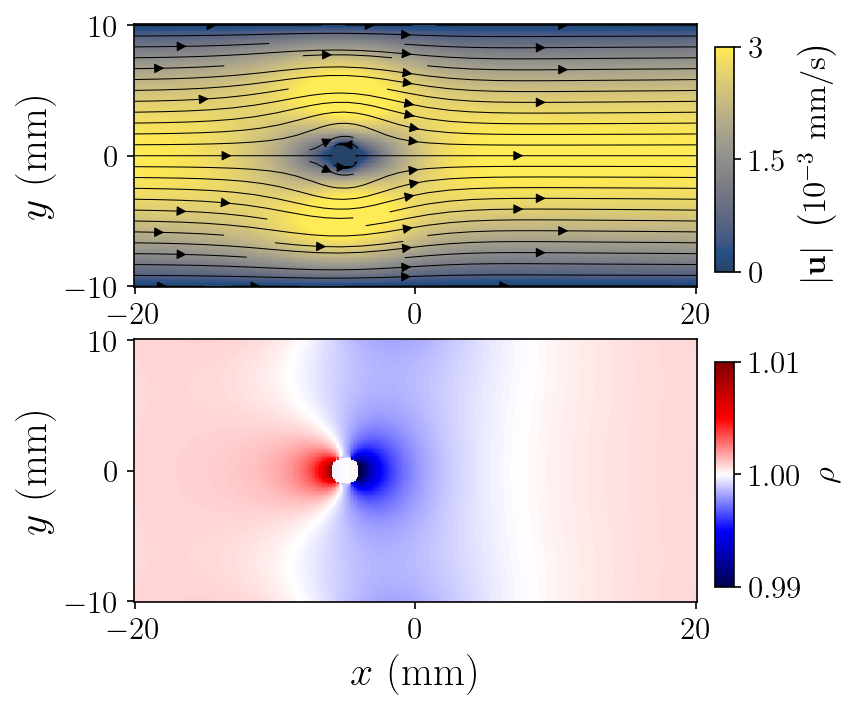

In [56]:
fig, axes = fluidOverview(fluidDf)
plt.show()